# CALTECH CONTROL PACKAGE

This notebook introduces core elements of the CalTech control package and provides various examples of using the with Tellurium.

# Preliminaries

In [2]:
try:
    import controlSBML as ctl
except:
    !pip install -q controlSBML
    import controlSBML as ctl

import control
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

## Antimony Models

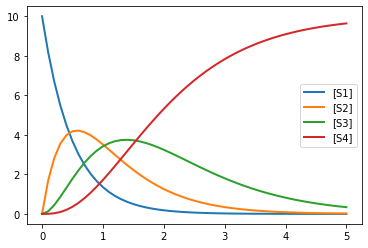

In [ ]:
LINEAR_MDL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
LINEAR_RR = te.loada(LINEAR_MDL)
LINEAR_DATA = LINEAR_RR.simulate()
LINEAR_RR.plot(LINEAR_DATA)

**System Equations**

$
\begin{eqnarray}
\dot{S}_1 & =&  -& k_1 S_1 & +&  0 S_2 &+& 0 S_3 \\
\dot{S}_2 &=& + & k_1 S_1  &-& k_2 S_2 &+& 0S_3 \\
\dot{S}_3 &=& +& 0S_1 &+& k_2 S_2 &-& k_3 S_3 \\
\dot{S}_4 &=& +& 0S_1 &+& 0 S_2 &+& k_3 S_3
\end{eqnarray}
$

# The ``control`` Package

Provides a way to define a "system", interconnect systems, analyze systems, and simulate system.


## Defining a System

A system is defined by a combination of a state transition function and an output function.
* The state transition function returns the time derivative of each state variable
* The output function returns the value of all outputs at the current state.

An example.

# Predator-Prey Example

In [10]:
def predprey_rhs(time, x_vec, u_vec, params):
    # Parameter setup
    a = params.get('a', 3.2)
    b = params.get('b', 0.6)
    c = params.get('c', 50.)
    d = params.get('d', 0.56)
    k = params.get('k', 125)
    r = params.get('r', 1.6)

    # Map the states into local variable names
    H = x_vec[0]
    L = x_vec[1]

    # Compute the control action (only allow addition of food)
    u_0 = u_vec if u_vec > 0 else 0

    # Compute the discrete updates
    dH = (r + u_0) * H * (1 - H/k) - (a * H * L)/(c + H)
    dL = b * (a * H *  L)/(c + H) - d * L

    return [dH, dL]


In [11]:
io_predprey = control.NonlinearIOSystem(
    predprey_rhs, None, inputs=('u'), outputs=('H', 'L'),
    states=('H', 'L'), name='predprey')

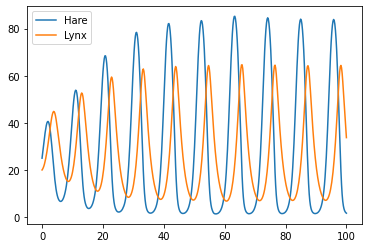

In [14]:
# Simulate the system
X0 = [25, 20]                 # Initial H, L
T = np.linspace(0, 100, 500)   # Simulation 70 years of time

# Simulate the system
t, y = control.input_output_response(io_predprey, T, 0, X0)

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Hare', 'Lynx'])
plt.show(block=False)

In [13]:
eqpt = control.find_eqpt(io_predprey, X0, 0)
eqpt

(array([20.58823529, 29.48096886]), array([0.]))

In [16]:
# Create a feedback controller. Step 1: Find an equalibrium point
eqpt = control.find_eqpt(io_predprey, X0, 0)
xeq = eqpt[0]                         # choose the nonzero equilibrium point
lin_predprey = control.linearize(io_predprey, xeq, 0)

# Step 2: Construct the controller via pole placement
K = control.place(lin_predprey.A, lin_predprey.B, [-0.1, -0.2])
A, B = lin_predprey.A, lin_predprey.B
C = np.array([[0, 1]])                # regulated output = number of lynxes
kf = -1/(C @ np.linalg.inv(A - B @ K) @ B)

/usr/local/lib/python3.7/dist-packages/control/iosys.py:1007: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [17]:
PARAM_DCT = {"kf": kf, "K": K}

# Construct the controller
def controllerOutfcn(time, x_vec, u_vec, parm_dct):
    K = parm_dct["K"]
    kf = parm_dct["kf"]
    return -K @ (u_vec[1:] - xeq) + kf * (u_vec[0] - xeq[1])


io_controller = control.NonlinearIOSystem(
  None,
  controllerOutfcn,
  inputs=('Ld', 'u1', 'u2'), outputs=1, name='control')

/usr/local/lib/python3.7/dist-packages/control/iosys.py:1007: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



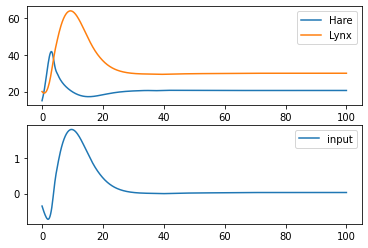

In [18]:
# Create the closed loop system
io_closed = control.interconnect(
  [io_predprey, io_controller],       # systems
  connections=[
    ['predprey.u', 'control.y[0]'],
    ['control.u1',  'predprey.H'],
    ['control.u2',  'predprey.L']
  ],
  inplist=['control.Ld'],
  outlist=['predprey.H', 'predprey.L', 'control.y[0]']
)

# Simulate the system
t, y = control.input_output_response(io_closed, T, 30, [15, 20.],
                                     params=PARAM_DCT)

# Plot the response
plt.figure(2)
plt.subplot(2, 1, 1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Hare', 'Lynx'])
plt.subplot(2, 1, 2)
plt.plot(t, y[2])
plt.legend(['input'])
plt.show(block=False)

# Simple Tellurium Example

* Creating a non-linear system object
  * Writing the state update function
  * Writing an output function
* Interconnecting with a controller

# Using ``controlSBML`` With ``control``

# Accuracy of Linear Models